In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = 0.5,
        m_rate = 0.6,
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.5,
        grow_factor = 0.5,
        scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 1
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

C:\Users\tcumi\github_repo\neural-network\python\ga.py:189: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)
C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))


Checkpoint 100, Accuracy: 0.8271604938271605, Loss: 0.6298727812590422
Checkpoint 200, Accuracy: 0.8395061728395061, Loss: 0.6230593080873843
Checkpoint 300, Accuracy: 0.8518518518518519, Loss: 0.6124670947039569
Checkpoint 400, Accuracy: 0.8580246913580247, Loss: 0.6105372111002604
Checkpoint 500, Accuracy: 0.8580246913580247, Loss: 0.5999041663275825


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None:
        title = '{} VS {}'.format(x_label, y_label)
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

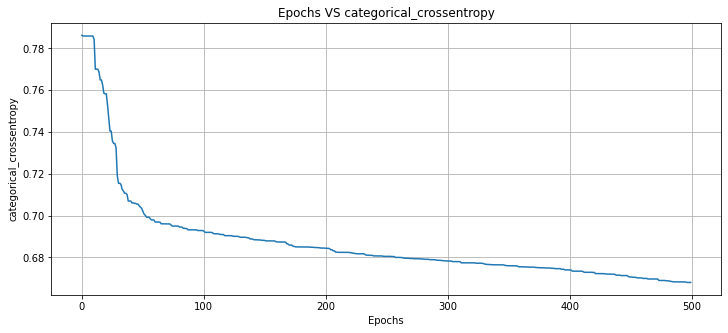

In [10]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.47106987]
 [0.22661729]
 [0.30231288]]
[1. 0. 0.] <-> [[0.7781139 ]
 [0.17319551]
 [0.0486906 ]]
[0. 0. 1.] <-> [[0.7770638 ]
 [0.17412941]
 [0.04880676]]
[0. 1. 0.] <-> [[0.58237094]
 [0.18076634]
 [0.23686273]]
[1. 0. 0.] <-> [[0.68226546]
 [0.25730473]
 [0.06042976]]
[0. 1. 0.] <-> [[0.9383642 ]
 [0.0366368 ]
 [0.02499899]]
[1. 0. 0.] <-> [[0.9390069 ]
 [0.03615633]
 [0.02483673]]
[1. 0. 0.] <-> [[0.9505521 ]
 [0.02779214]
 [0.02165582]]
[0. 0. 1.] <-> [[0.21740822]
 [0.43775225]
 [0.3448395 ]]
[1. 0. 0.] <-> [[0.4537478 ]
 [0.23986839]
 [0.3063838 ]]
[1. 0. 0.] <-> [[0.9226811 ]
 [0.04871737]
 [0.02860147]]
[0. 1. 0.] <-> [[0.627151  ]
 [0.2651134 ]
 [0.10773557]]
[0. 1. 0.] <-> [[0.12325794]
 [0.4623494 ]
 [0.4143926 ]]
[0. 0. 1.] <-> [[0.95578766]
 [0.02421708]
 [0.0199952 ]]
[1. 0. 0.] <-> [[0.6978422 ]
 [0.24408695]
 [0.05807084]]
[1. 0. 0.] <-> [[0.9423486 ]
 [0.03368084]
 [0.0239706 ]]
[1. 0. 0.] <-> [[0.9087347 ]
 [0.05990755]
 [0.03135771]]
[1. 0. 0.] <->

C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))


In [12]:
# Testing Performance

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8271604938271605, 'mean_square_error': 2.8082091139262726, 'categorical_crossentropy': 0.6298727812590422, 'precision': 0.7407407407407407, 'recall': 0.7407407407407407, 'f1': 0.7407407407407407, 'essential_metrics': {0: {'tp_hit': 74, 'fp_hit': 10, 'tn_hit': 18, 'fn_hit': 6}, 1: {'tp_hit': 5, 'fp_hit': 10, 'tn_hit': 83, 'fn_hit': 10}, 2: {'tp_hit': 1, 'fp_hit': 8, 'tn_hit': 87, 'fn_hit': 12}}, 'checkpoint': 100} 


{'accuracy': 0.8395061728395061, 'mean_square_error': 2.83932880054467, 'categorical_crossentropy': 0.6230593080873843, 'precision': 0.7592592592592593, 'recall': 0.7592592592592593, 'f1': 0.7592592592592593, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 13, 'tn_hit': 15, 'fn_hit': 4}, 1: {'tp_hit': 6, 'fp_hit': 13, 'tn_hit': 80, 'fn_hit': 9}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 13}}, 'checkpoint': 200} 


{'accuracy': 0.8518518518518519, 'mean_square_error': 2.819164118554073, 'categorical_crossentropy': 0.6124670947039569, 'precision':

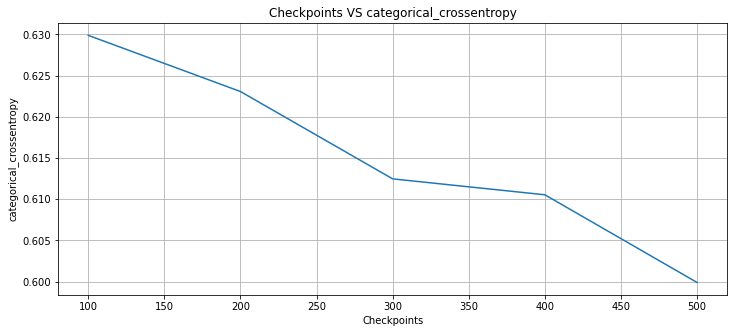

In [14]:
cat_cross = [ ckp[model.loss_fn] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [cat_cross], x_label = 'Checkpoints', \
    y_label = model.loss_fn)

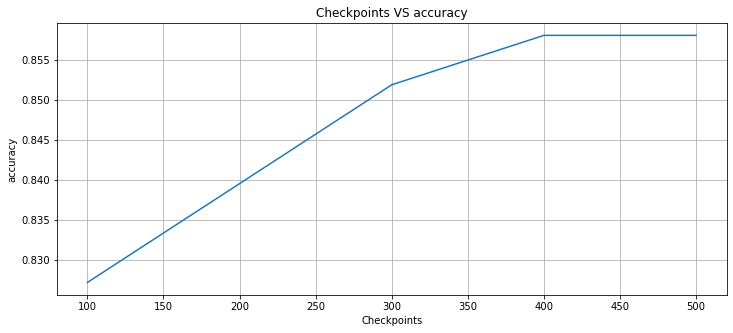

In [15]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [16]:
print(model)

Layer 1
Neuron 0: weights:
[[-0.0498622]
 [-1.3041798]
 [ 0.7796026]
 [-2.612258 ]
 [ 2.6927452]]
 bias: [1.0529455]

Neuron 1: weights:
[[ 1.6565169 ]
 [-0.49802995]
 [-2.3669417 ]
 [ 1.3088733 ]
 [ 0.9892465 ]]
 bias: [0.12440804]

Neuron 2: weights:
[[-0.26847476]
 [ 1.66691   ]
 [ 2.8490946 ]
 [ 2.088506  ]
 [-0.15182485]]
 bias: [1.0441965]

Neuron 3: weights:
[[-3.       ]
 [-2.8182786]
 [-3.       ]
 [-3.       ]
 [-2.908025 ]]
 bias: [0.79354805]

$
Layer 2
Neuron 0: weights:
[[ 2.4158378 ]
 [-3.        ]
 [ 2.5684025 ]
 [ 0.12402564]]
 bias: [2.5877857]

Neuron 1: weights:
[[1.5796567]
 [2.7247517]
 [3.       ]
 [1.3430991]]
 bias: [-1.8442317]

Neuron 2: weights:
[[-0.8515428]
 [-1.287807 ]
 [ 3.       ]
 [-1.0588298]]
 bias: [2.811419]

$

